https://sgpp.sparsegrids.org/docs/example_refinement_py.html
https://sgpp.github.io/SGpp/example_combigrid_py.html

In [3]:
#allows any changes on external files to be loaded on code run.
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../')

debug tuple <class 'numpy.ndarray'>
debug tuple <class 'numpy.ndarray'>


/home/djdaniel/GENE_UQ/SGPP_testing/../GENE_ML/gene_ml/test_functions/max_of_many_gaussians.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


TypeError: MaxOfManyGaussians.plot_2d_gaussians() missing 1 required positional argument: 'ax'

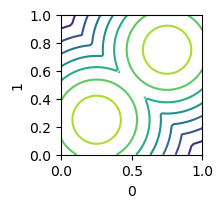

In [4]:

from GENE_ML.gene_ml.test_functions.max_of_many_gaussians import MaxOfManyGaussians
import numpy as np


num_dim = 2
bounds = [(0,1) for i in range(num_dim)]
num_gaussians = 2
std=0.5
mmg = MaxOfManyGaussians(num_dim, bounds)#num_dim, num_gaussians, bounds, mean_bounds, std_bounds, seed=10)

mmg.specify_gaussians(means=np.array([[0.25,0.25], [0.75,0.75]]), stds = np.array([[std,std],[std,std]]))
# mmg.plot_2d_gaussians(extra=0, grid_size=200, plot_bounds=[(0,1),(0,1)], style='contour')
# mmg.plot_2D_of_many(which2=(0,1), style='contour')
mmg.plot_matrix_contour()
if num_dim == 2: mmg.plot_2d_gaussians()

# SG++ Example With My Function

In [18]:
# import pysgpp library
import pysgpp
import inspect
f = lambda x0, x1: mmg.evaluate([x0, x1])
# f = lambda x0, x1: 16.0 * (x0-1)*x0 * (x1-1)*x1*x1

dim = 2
poly_basis_degree = 3
grid = pysgpp.Grid.createPolyBoundaryGrid(dim, poly_basis_degree)
# grid = pysgpp.Grid.createLinearBoundaryGrid(dim)

gridStorage = grid.getStorage()

#create regular sparse grid, level 3
initial_level = 2
gridGen = grid.getGenerator()

gridGen.regular(initial_level)

print("number of initial grid points:    {}".format(gridStorage.getSize()))

alpha = pysgpp.DataVector(gridStorage.getSize())
print("length of alpha vector:           {}".format(alpha.getSize()))
# Obtain function values and refine adaptively 5 times
num_refinement_steps =25

x0, x1, x0_leaf, x1_leaf = [], [], [], []

#We don't want to run the function for every point so a wrapper function should check to see if the point has been ran and if it has return that value
def dummpy_runner(f, samples, labeled_samples=None):
    if type(labeled_samples) != type(None):
        # print('LABELED SAMPLES',labeled_samples.items())
        for k, v in samples.items():
            if k in labeled_samples.keys():
                samples[k] = labeled_samples[k]
            else:
                samples[k] = f(*k)
    else:
        for k, v in samples.items():
            samples[k] = f(*k)
    return samples
            
labeled_samples=None
samples = {}
# I want to know if there are any samples that have never been a leaf
was_leaf = []

samples_s = []
is_leaf_s = []
for refnum in range(num_refinement_steps):
    print('REFINEMENT STEP', refnum+1)
    # make samples dict
    for i in range(gridStorage.getSize()):
        gp = gridStorage.getPoint(i)
        x0 = gp.getStandardCoordinate(0)
        x1 = gp.getStandardCoordinate(1)
        samples[(x0,x1)] = None
        if i > len(was_leaf):
            # print('APPENDING')
            was_leaf.append(False)
    was_leaf.append(False)
    
    # label samples
    samples = dummpy_runner(f, samples, labeled_samples)
    samples_s.append(samples.copy())
    labeled_samples = samples.copy()
    
    # set function values in alpha
    is_leaf = []
    for i in range(gridStorage.getSize()):
        gp = gridStorage.getPoint(i)
        # print(dir(gp))
        # break
        x0 = gp.getStandardCoordinate(0)
        x1 = gp.getStandardCoordinate(1)
        # print('function value',f(x0,x1), type(f(x0,x1)))
        # print('dict value',samples[(x0,x1)], type(samples[(x0,x1)]))
        alpha[i] = samples[(x0,x1)]
        if gp.isLeaf():
            was_leaf[i] = True
            is_leaf.append(True)
        else:
            is_leaf.append(False)     
    is_leaf_s.append(is_leaf)
    # break
    pysgpp.createOperationHierarchisation(grid).doHierarchisation(alpha)
    gridGen.refine(pysgpp.SurplusRefinementFunctor(alpha, 1))
    print("refinement step {}, new grid size: {}".format(refnum+1, gridStorage.getSize()))    
    alpha.resizeZero(gridStorage.getSize())

number of initial grid points:    21
length of alpha vector:           21
REFINEMENT STEP 1
refinement step 1, new grid size: 29
REFINEMENT STEP 2
refinement step 2, new grid size: 39
REFINEMENT STEP 3
refinement step 3, new grid size: 47
REFINEMENT STEP 4
refinement step 4, new grid size: 57
REFINEMENT STEP 5
refinement step 5, new grid size: 67
REFINEMENT STEP 6
refinement step 6, new grid size: 79
REFINEMENT STEP 7
refinement step 7, new grid size: 89
REFINEMENT STEP 8
refinement step 8, new grid size: 101
REFINEMENT STEP 9
refinement step 9, new grid size: 102
REFINEMENT STEP 10
refinement step 10, new grid size: 103
REFINEMENT STEP 11
refinement step 11, new grid size: 107
REFINEMENT STEP 12
refinement step 12, new grid size: 111
REFINEMENT STEP 13
refinement step 13, new grid size: 123
REFINEMENT STEP 14
refinement step 14, new grid size: 137
REFINEMENT STEP 15
refinement step 15, new grid size: 149
REFINEMENT STEP 16
refinement step 16, new grid size: 163
REFINEMENT STEP 17
refi

In [140]:
print(len(samples_s[0]))
print(len(is_leaf_s[0]))


21
21


In [117]:
grid_storage_s[-1].getSize()

969

In [101]:
print(dir(gp))

print(gp.__dict__)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__weakref__', 'assign', 'equals', 'get', 'getDimension', 'getHash', 'getIndex', 'getLeftBoundaryPoint', 'getLeftChild', 'getLeftLevelZero', 'getLevel', 'getLevelMax', 'getLevelMin', 'getLevelSum', 'getParent', 'getRightBoundaryPoint', 'getRightChild', 'getRightLevelZero', 'getRoot', 'getStandardCoordinate', 'getStandardCoordinates', 'isHierarchicalAncestor', 'isInnerPoint', 'isLeaf', 'push', 'rehash', 'serialize', 'set', 'setAsHierarchicalGridPoint', 'setLeaf', 'this', 'thisown', 'toString']
{'this': <Swig Object of type 'sgpp::base::GridPoint *' at 0x708bdc2a8750>}


In [30]:
grid.b

AttributeError: 'Grid' object has no attribute 'b'

In [24]:
import inspect

def print_inputs(function):
    signature = inspect.signature(function)
    for param in signature.parameters.values():
        print(param)

print_inputs(pysgpp.SurplusRefinementFunctor)
dir(pysgpp.SurplusRefinementFunctor)

alpha: 'DataVector'
refinements_num: 'size_t' = 1
threshold: 'double' = 0.0


['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__swig_destroy__',
 '__weakref__',
 'getRefinementThreshold',
 'getRefinementsNum',
 'getTotalRefinementValue',
 'start',
 'thisown']

In [81]:
print(was_leaf)

[False False False ... False False False]


In [ ]:
was_leaf = []
for is_leaf in is_leaf_s:
    

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (200,) + inhomogeneous part.

len samples 37
len samples 117
len samples 267


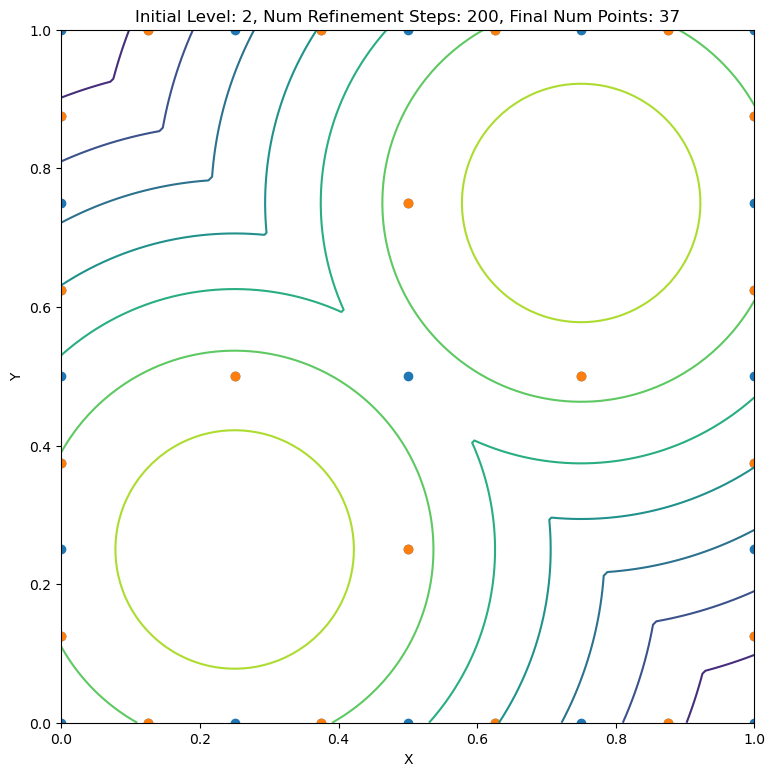

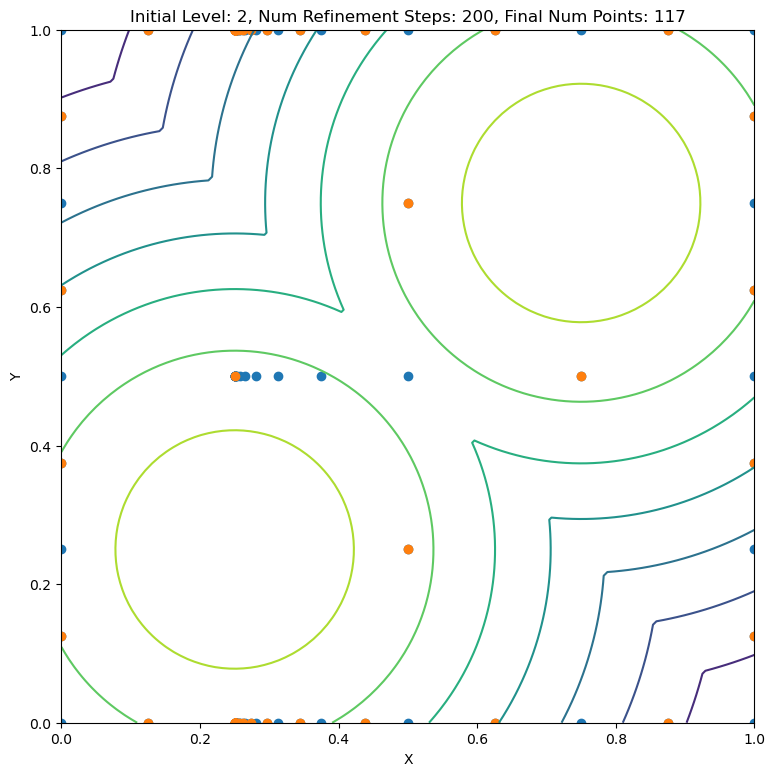

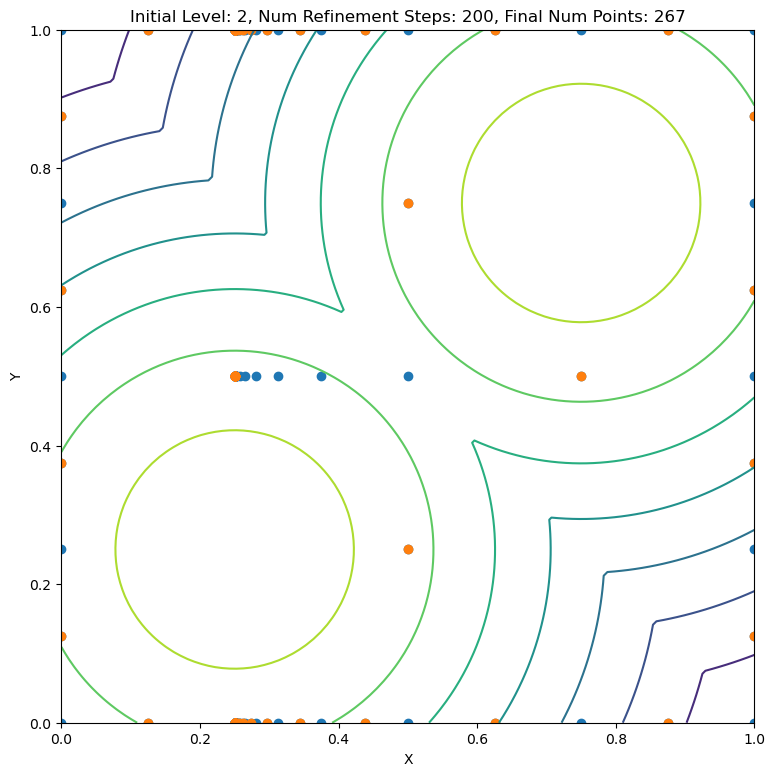

In [9]:
import matplotlib.pyplot as plt

samples_ss = [samples_s[4]] + [samples_s[20]] + [samples_s[50]]
is_leaf_ss = [is_leaf_s[4]] + [is_leaf_s[20]] + [is_leaf_s[50]]



for samples, is_leaf in zip(samples_ss, is_leaf_ss):
    print('len samples', len(samples))
    x0_ = []
    x1_ = []
    
    x0_leaf, x1_leaf = [], []
    for sample, leaf in zip(samples, is_leaf):
        x0, x1 = sample
        x0_.append(x0)
        x1_.append(x1)
        if leaf:
            x0_leaf.append(x0)
            x1_leaf.append(x1)

    fig, ax = plt.subplots(1,1, figsize=(9,9))
    ax.set_aspect(1)
    mmg.plot_2d_gaussians(ax, onlyContour=True, title=f"Initial Level: {initial_level}, Num Refinement Steps: {num_refinement_steps}, Final Num Points: {len(x0_)}")
    ax.scatter(x0_,x1_)
    ax.scatter(x0_leaf, x1_leaf)


# Plotting SG++ Grid

82
233


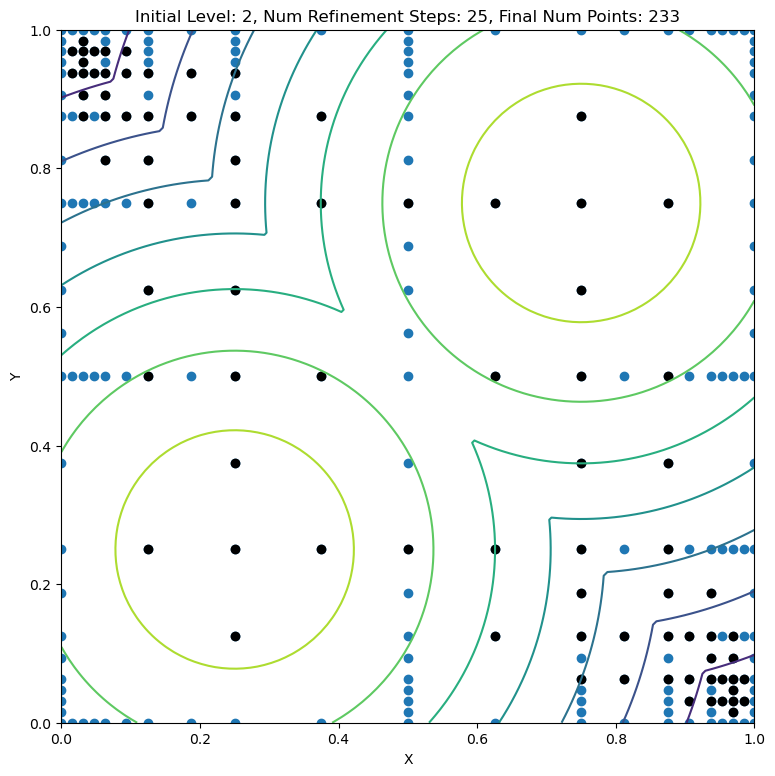

In [19]:
import matplotlib.pyplot as plt



x0 = []
x1 = []

x0_leaf = []
x1_leaf = []

x0_was_leaf = []
x1_was_leaf = []

x0_inner = []
x1_inner = []

x0_ancestor = []
x1_ancestor = []
for i in range(gridStorage.getSize()):
    gp = gridStorage.getPoint(i)
    
    if gp.isLeaf():
        x0_leaf.append(gp.getStandardCoordinate(0))
        x1_leaf.append(gp.getStandardCoordinate(1))
    
    if gp.isInnerPoint():
        x0_inner.append(gp.getStandardCoordinate(0))
        x1_inner.append(gp.getStandardCoordinate(1))
    
    try:
        if gp.isHierarchicalAncestor():
            x0_ancestor.append(gp.getStandardCoordinate(0))
            x1_ancestor.append(gp.getStandardCoordinate(1))
    except:
        None
        
    x0.append(gp.getStandardCoordinate(0))
    x1.append(gp.getStandardCoordinate(1))
    
    if i<len(was_leaf):
        if was_leaf[i]:
            x0_was_leaf.append(gp.getStandardCoordinate(0))
            x1_was_leaf.append(gp.getStandardCoordinate(1))
# plt.figure(dpi=100)
# plt.plot(x0,x1, '.')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.xlim(0,1)
# plt.ylim(0,1)

fig, ax = plt.subplots(1,1, figsize=(9,9))
ax.set_aspect(1)
mmg.plot_2d_gaussians(ax, onlyContour=True, title=f"Initial Level: {initial_level}, Num Refinement Steps: {num_refinement_steps}, Final Num Points: {len(x0)}")

ax.scatter(x0, x1)
# ax.scatter(x0_ancestor, x1_ancestor, color='black')
plt.scatter(x0_was_leaf, x1_was_leaf, color='black')
# plt.scatter(x0_leaf, x1_leaf, color='orange')
# plt.scatter(x0_inner, x1_inner, color='black')
# plt.scatter(x0_was_leaf, x1_was_leaf, color='orange')



print(len(x0_was_leaf))
print(len(x0))

# Possible Changes Expressed

In [64]:
import inspect
import pysgpp

print(inspect.getfile(pysgpp.Grid))

/home/djdaniel/anaconda3/envs/gene_ml/lib/python3.12/site-packages/pysgpp/pysgpp_swig.py


number of initial grid points:    1
length of alpha vector:           1
refinement step 1, new grid size: 5
refinement step 2, new grid size: 9
refinement step 3, new grid size: 12
refinement step 4, new grid size: 15
refinement step 5, new grid size: 17
refinement step 6, new grid size: 21
refinement step 7, new grid size: 25
refinement step 8, new grid size: 29
refinement step 9, new grid size: 33
refinement step 10, new grid size: 37
refinement step 11, new grid size: 41
refinement step 12, new grid size: 45
refinement step 13, new grid size: 49
refinement step 14, new grid size: 53
refinement step 15, new grid size: 58
refinement step 16, new grid size: 62
refinement step 17, new grid size: 67
refinement step 18, new grid size: 69
refinement step 19, new grid size: 71
refinement step 20, new grid size: 73
73


0.875

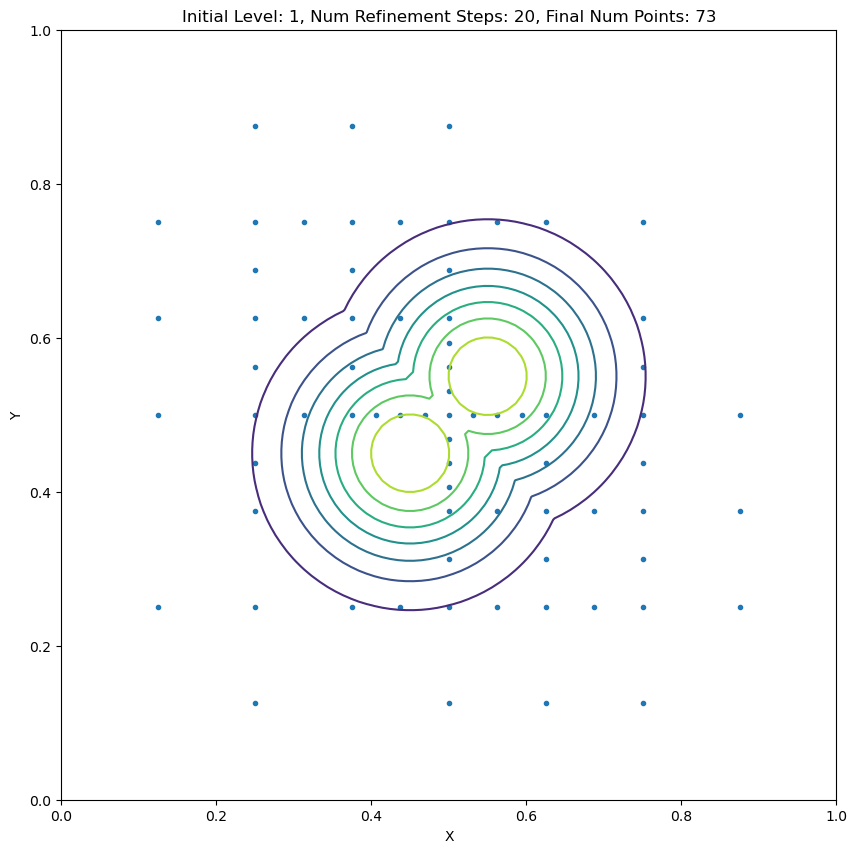

In [74]:
# import pysgpp library
import pysgpp

f = lambda x0, x1: mmg.evaluate([x0, x1])
# f = lambda x0, x1: 16.0 * (x0-1)*x0 * (x1-1)*x1*x1

dim = 2
level = 4
p = 3
hasBoundary = True

# basis1d = pysgpp.SBsplineBase(p)
# basis = pysgpp.HeterogeneousBasis(dim, basis1d)
# grid = pysgpp.Grid.createModBsplineGrid(dim, p)
# combiGrid = pysgpp.CombinationGrid.fromRegularSparse(dim, level, basis, hasBoundary)
# gridStorage = pysgpp.HashGridStorage(dim)
# max_grid_points=1000

# adaptivity of grid generation
# gamma = 0.95
# gridGen = pysgpp.OptIterativeGridGeneratorRitterNovak(f, grid, max_grid_points, gamma)

dim = 2
poly_basis_degree = 20
# grid = pysgpp.Grid.createPolyGrid(dim, poly_basis_degree)
grid = pysgpp.Grid.createLinearGrid(dim)
gridStorage = grid.getStorage()
#create regular sparse grid, level 3
initial_level = 1
gridGen = grid.getGenerator()
gridGen.regular(initial_level)
print("number of initial grid points:    {}".format(gridStorage.getSize()))

alpha = pysgpp.DataVector(gridStorage.getSize())
print("length of alpha vector:           {}".format(alpha.getSize()))
# Obtain function values and refine adaptively 5 times
num_refinement_steps = 20
for refnum in range(num_refinement_steps):
    # set function values in alpha
    for i in range(gridStorage.getSize()):
        gp = gridStorage.getPoint(i)
        alpha[i] = f(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1))
    pysgpp.createOperationHierarchisation(grid).doHierarchisation(alpha)
    gridGen.refine(pysgpp.SurplusRefinementFunctor(alpha, 1))
    print("refinement step {}, new grid size: {}".format(refnum+1, gridStorage.getSize()))    
    alpha.resizeZero(gridStorage.getSize())
    
    
    
    
    
    
    
    
import matplotlib.pyplot as plt
x0 = []
x1 = []

for i in range(gridStorage.getSize()):
    gp = gridStorage.getPoint(i)
    x0.append(gp.getStandardCoordinate(0))
    x1.append(gp.getStandardCoordinate(1))
    
# plt.figure(dpi=100)
# plt.plot(x0,x1, '.')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.xlim(0,1)
# plt.ylim(0,1)
mmg.plot_2d_gaussians(onlyContour=True, sample_points=(x0,x1), title=f"Initial Level: {initial_level}, Num Refinement Steps: {num_refinement_steps}, Final Num Points: {len(x0)}")


print(len(x0))

np.max(x1)


In [77]:
inspect.getmembers(grid)

[('__class__', pysgpp.pysgpp_swig.Grid),
 ('__delattr__',
  <method-wrapper '__delattr__' of Grid object at 0x74fc80d3eed0>),
 ('__dict__',
  {'this': <Swig Object of type 'sgpp::datadriven::Grid *' at 0x74fc80d7fed0>}),
 ('__dir__', <function Grid.__dir__()>),
 ('__doc__',
  '\n\n    `Grid(other)`  \n\n    abstract base class for all types grids used in sgpp the class gives pure\n    virtual function definitions that have to be implemented by all types of grids  \n\n    Constructors\n    ------------\n    * `Grid(other)`  \n\n        delete copy constructor  \n\n        Parameters:  \n        * `other` :  \n\n    C++ includes: Grid.hpp\n\n    '),
 ('__eq__', <method-wrapper '__eq__' of Grid object at 0x74fc80d3eed0>),
 ('__format__', <function Grid.__format__(format_spec, /)>),
 ('__ge__', <method-wrapper '__ge__' of Grid object at 0x74fc80d3eed0>),
 ('__getattribute__',
  <method-wrapper '__getattribute__' of Grid object at 0x74fc80d3eed0>),
 ('__getstate__', <function Grid.__getstat

# As it is in the Example
https://sgpp.sparsegrids.org/docs/example_refinement_py.html

In [1]:
# import pysgpp library
import pysgpp

f = lambda x0, x1: 16.0 * (x0-1)*x0 * (x1-1)*x1*x1
dim = 2
grid = pysgpp.Grid.createPolyGrid(dim, 3)
gridStorage = grid.getStorage()

#create regular sparse grid, level 3
level = 5
gridGen = grid.getGenerator()
gridGen.regular(level)
print("number of initial grid points:    {}".format(gridStorage.getSize()))

alpha = pysgpp.DataVector(gridStorage.getSize())
print("length of alpha vector:           {}".format(alpha.getSize()))
# Obtain function values and refine adaptively 5 times
for refnum in range(5):
    # set function values in alpha
    for i in range(gridStorage.getSize()):
        gp = gridStorage.getPoint(i)
        alpha[i] = f(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1))
    pysgpp.createOperationHierarchisation(grid).doHierarchisation(alpha)
    gridGen.refine(pysgpp.SurplusRefinementFunctor(alpha, 1))
    print("refinement step {}, new grid size: {}".format(refnum+1, gridStorage.getSize()))    
    alpha.resizeZero(gridStorage.getSize())

number of initial grid points:    129
length of alpha vector:           129
refinement step 1, new grid size: 133
refinement step 2, new grid size: 137
refinement step 3, new grid size: 141
refinement step 4, new grid size: 145
refinement step 5, new grid size: 149


# Possible Modifications

There are clearly more efficient approaches than to set the function values for all grid points and to hierarchize the whole grid each time. But this works even where no efficient alternatives are available and suffices for demonstration purposes.

This use of the SurplusRefinementFunctor takes as arguments the coefficient vector (it doesn't have to be the coefficient vector, it could be something modified!) and the number of grid points to refine (if available). It bases its refinement decision on the absolute values of the vector's entries, *choosing the largest ones*. Other refinement functors are available or can be implemented.

# Combi Grid Example

Value of test function at [0.12 0.34]: 0.820974
Value of combined sparse grid interpolant at [0.12 0.34]: 0.774666
Level of selected full grid with index 1: [3 1]
Value of full grid interpolant at [0.12 0.34]: 0.564036


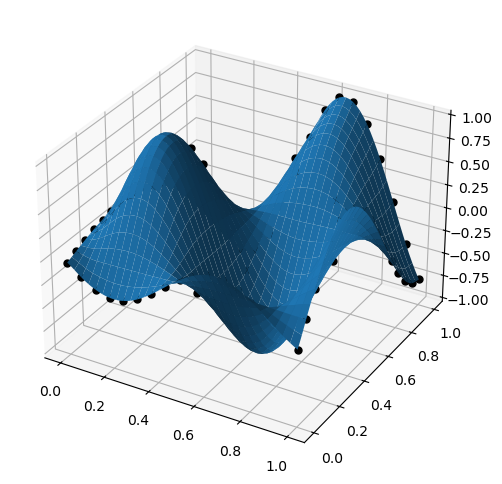

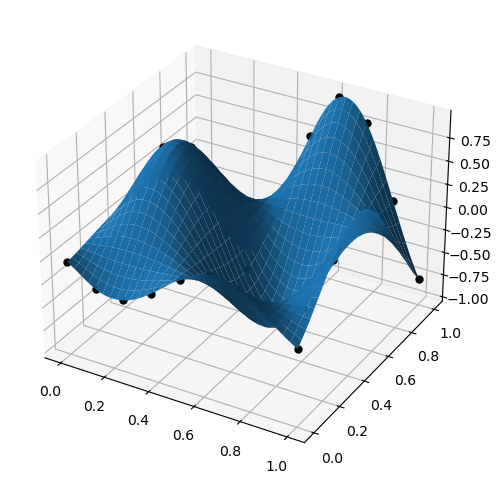

In [78]:
import pysgpp
import numpy as np
import sys
 
# skip plotting if Matplotlib cannot be imported (e.g., not installed or no GUI available)
try:
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  doPlot = True
except ImportError:
  doPlot = False
  
def plotFunction(opEval, surpluses, X):
  if not doPlot: return
 
  # generate a meshgrid for plotting
  xx0 = np.linspace(0, 1, 65)
  xx1 = np.linspace(0, 1, 65)
  XX0, XX1 = np.meshgrid(xx0, xx1)
  XX = pysgpp.DataMatrix(np.column_stack([XX0.flatten(), XX1.flatten()]))
 
  # evaluate interpolant at meshgrid
  YY = pysgpp.DataVector(0)
  opEval.multiEval(surpluses, XX, YY)
 
  # convert resulting sgpp::base::DataVector to NumPy array
  YY = np.reshape(np.array([YY[k] for k in range(YY.getSize())]), XX0.shape)
 
  # actual plotting
  fig = plt.figure(figsize=(6, 6))
  ax = fig.add_subplot(projection="3d")
  ax.plot_surface(XX0, XX1, YY)
  ax.plot(X[:,0], X[:,1], "k.", zs=f(X[:,0], X[:,1]), ms=10)
  
# dimensionality
dim = 2
# regular level
n = 4
# B-spline degree
p = 3
# whether there are points on the boundary
hasBoundary = True
# test function
f = lambda XX0, XX1: np.sin(7*XX0-3)*np.cos(5*XX1-5)
 
# disable log output
pysgpp.Printer.getInstance().setVerbosity(-1)

basis1d = pysgpp.SBsplineBase(p)
basis = pysgpp.HeterogeneousBasis(dim, basis1d)

combiGrid = pysgpp.CombinationGrid.fromRegularSparse(dim, n, basis, hasBoundary)

gridStorage = pysgpp.HashGridStorage(dim)
combiGrid.combinePoints(gridStorage)
 
# convert grid storage to array with coordinates of grid points
X = np.array([[gridStorage.getPoint(k).getStandardCoordinate(d) for d in range(dim)]
              for k in range(gridStorage.getSize())])
 
# evaluate test function at grid points
fX = pysgpp.DataVector(f(X[:,0], X[:,1]))

values = pysgpp.DataVectorVector()
combiGrid.distributeValuesToFullGrids(gridStorage, fX, values)

# copy the values (surpluses will be modified in-place)
surpluses = pysgpp.DataVectorVector(values)
 
# create pole operation
opPole = pysgpp.OperationPoleVector()
pysgpp.OperationPoleHierarchisationGeneral.fromHeterogenerousBasis(basis, opPole)
 
# create operation for unidirectional principle and hierarchize in-place
opHier = pysgpp.OperationUPCombinationGrid(combiGrid, opPole)
opHier.apply(surpluses)

# test point at which to evaluate
x = [0.12, 0.34]
xDv = pysgpp.DataVector(x)
print("Value of test function at {}: {:.6g}".format(np.array(x), f(*x)))
# create operation for evaluating and evaluate
opEval = pysgpp.OperationEvalCombinationGrid(combiGrid)
y = opEval.eval(surpluses, xDv)
print("Value of combined sparse grid interpolant at {}: {:.6g}".format(np.array(x), y))
# plot
plotFunction(opEval, surpluses, X)

# select the second full grid of the combination grid (arbitrary choice)
fullGridIndex = 1
fullGrid = combiGrid.getFullGrids()[fullGridIndex]
l = fullGrid.getLevel()
print("Level of selected full grid with index {}: {}".format(fullGridIndex, np.array(l)))
 
# create operation for evaluating and evaluate
opEval = pysgpp.OperationEvalFullGrid(fullGrid)
y = opEval.eval(surpluses[fullGridIndex], xDv)
print("Value of full grid interpolant at {}: {:.6g}".format(np.array(x), y))
 
# compute grid points of full grid
X = pysgpp.DataMatrix(0, 0)
pysgpp.IndexVectorRange.getPoints(fullGrid, X)
 
# convert resulting sgpp::base::DataMatrix to NumPy array
X = np.array([[X.get(k, j) for j in range(X.getNcols())] for k in range(X.getNrows())])
 
# plot
plotFunction(opEval, surpluses[fullGridIndex], X)
 
if doPlot: plt.show()
else: print("Skipping plots due to failed import of Matplotlib.")

# Value of test function at [0.12 0.34]: 0.820974
# Value of combined sparse grid interpolant at [0.12 0.34]: 0.774666
# Level of selected full grid with index 1: [3 1]
# Value of full grid interpolant at [0.12 0.34]: 0.564036

# Dumpster

Zmax [[2.08402576e-15 4.93065219e-15 1.14637732e-14 ... 1.54583104e-11
  9.08788489e-12 5.27040354e-12]
 [4.03051153e-15 9.53589484e-15 2.21709688e-14 ... 3.49335321e-11
  2.05372974e-11 1.19103451e-11]
 [7.68279801e-15 1.81769370e-14 4.22614038e-14 ... 7.74691806e-11
  4.55438515e-11 2.64125789e-11]
 ...
 [1.03537511e-10 2.19658390e-10 4.57714128e-10 ... 3.48902294e-11
  1.85049623e-11 9.68165623e-12]
 [6.18418181e-11 1.31199543e-10 2.73387621e-10 ... 1.90328991e-11
  1.00946048e-11 5.28142088e-12]
 [3.64640152e-11 7.73596618e-11 1.61198533e-10 ... 1.02372420e-11
  5.42959391e-12 2.84072245e-12]]


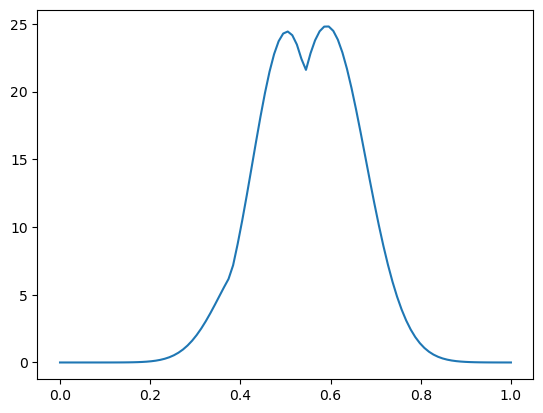

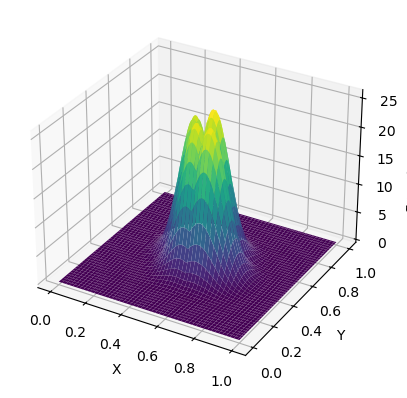

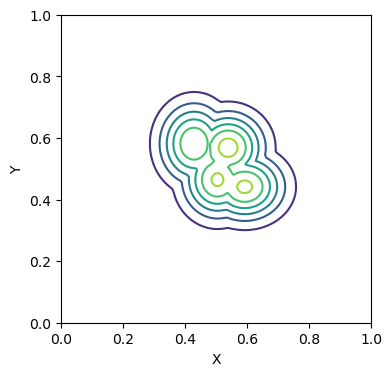

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

class MaxOfManyGaussians():
    def __init__(self, ndim, num_gaussians, bounds, std_bounds, rg):
        self.ndim = ndim
        self.bounds = bounds
        self.std_bounds = np.array(std_bounds)
        self.num_gaussians = num_gaussians
        self.rg = rg
        self.gaussians = self.generate_gaussians()

    def generate_gaussians(self):
        # Create a grid of points
        gaussians = []
        # Generate multiple 2D Gaussians
        for _ in range(self.num_gaussians):
            mean = []
            for b in self.bounds:
                mean.append(self.rg.uniform(*b, 1)[0])
            mean = np.array(mean)
            cov_bounds = self.std_bounds
            # cov = self.rg.uniform(*cov_bounds, (self.ndim, self.ndim))
            # cov = np.dot(cov, cov.T)  # Ensure the covariance matrix is positive semi-definite
            cov = np.diag(self.rg.uniform(*cov_bounds, (self.ndim,self.ndim)))
            gaussians.append(multivariate_normal(mean, cov))
        return gaussians

    def evaluate(self, pos):
        pos = np.array(pos)
        Z = []
        for g in self.gaussians:
            Z.append(g.pdf(pos))
        Zmax = np.max(np.stack(Z), axis = 0)
        # print('po', pos, Zmax)
        # print('shape',pos.shape, Zmax.shape)
        if len(pos)>2:
            Zmax[pos[:,:,0]>1] = 0
            Zmax[pos[:,:,1]>1] = 0
            Zmax[pos[:,:,0]<0] = 0
            Zmax[pos[:,:,1]<0] = 0        
        else:
            if (pos < 0).any() or (pos > 1).any():
                Zmax = 0
        print('Zmax',Zmax)
        # print('shape',pos.shape, Zmax.shape)
        # fixed bounds to 0 and 1, must be consistent with bounds inserted.
        # if (pos > 1).any() or (pos < 0).any():
        #     Zmax = np.zeros(Zmax.shape)
        return Zmax

    def plot_2d_gaussians(self, grid_size=100, onlyContour=False):
        if self.ndim != 2:
            raise ValueError('Daniel Says: n_dim must equil 2')
        extra = 1-self.bounds[0][1]
        xlow, xhigh = self.bounds[0][0]-extra, self.bounds[0][1]+extra
        ylow, yhigh = self.bounds[1][0]-extra, self.bounds[1][1]+extra
        x = np.linspace(xlow, xhigh, grid_size)
        y = np.linspace(ylow, yhigh, grid_size)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))
                
        
        Zmax = self.evaluate(pos)
        
        z = []
        yy = 0.45
        x_at_y = [(xi, yy) for xi in x]
        for g in self.gaussians:
            z.append(g.pdf(x_at_y))
        zmax = np.max(np.stack(z), axis = 0)
        #slice
        if not onlyContour:
            plt.figure()
            plt.plot(x, zmax)
            plt.show()
            
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot_surface(X, Y, Zmax, cmap='viridis')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Function Value')
            # ax.set_title('2D Surface of Multimodal Multivariate Gaussian Distribution')
            ax.view_init(elev=30, azim=30-90)

        fig = plt.figure(figsize=(4,4))
        plt.contour(X,Y,Zmax)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xlabel('X')
        plt.ylabel('Y')


seed = 10
rg = np.random.default_rng(seed=seed)
mmg = MaxOfManyGaussians(2, 5, [(0.4,0.6), (0.4,0.6)], std_bounds=(0.005,0.008), rg=rg)
# mmg = MaxOfManyGaussians(2, 5, [(0,1), (0,1)], std_bounds=(0.1,0.1), rg=rg)

mmg.plot_2d_gaussians()

# max_value, max_pos = generate_2d_gaussians(num_gaussians, grid_size)
# print(f"Maximum Gaussian value: {max_value} at position {max_pos}")



In [16]:
pos = np.array([0,4,5,1])

(pos > 1).any()

True

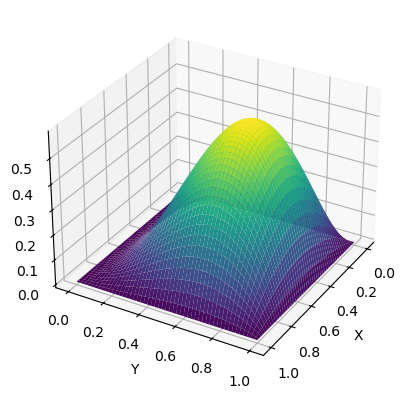

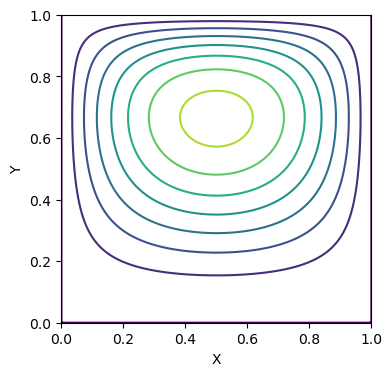

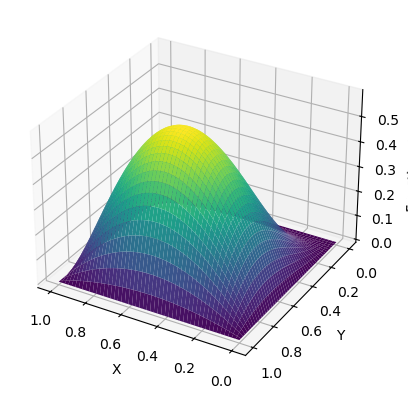

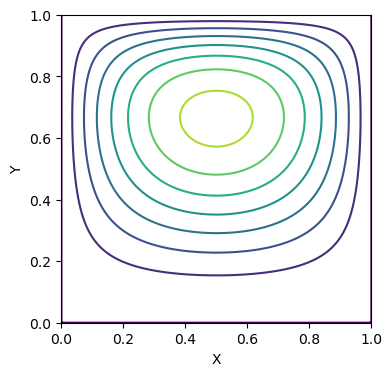

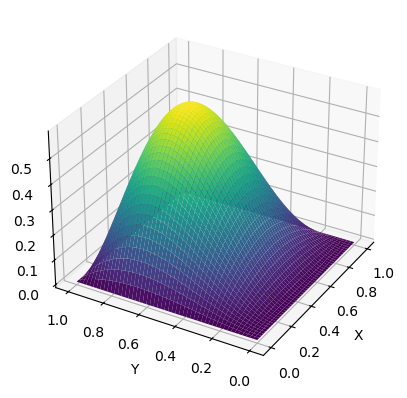

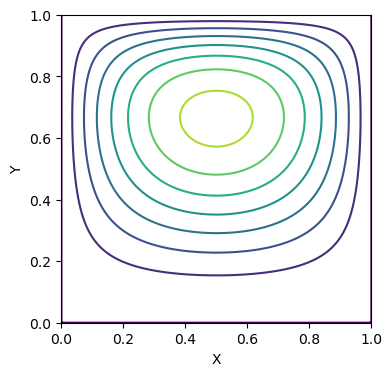

In [17]:
f = lambda x0, x1: 16.0 * (x0-1)*x0 * (x1-1)*x1*x1

# Generate a grid of coordinates
x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Calculate the function value at each coordinate in the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f(X[i, j], Y[i, j])

def plot_surface(X,Y,Z, elev, azim):
    # Plot the 2D surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Function Value')
    ax.view_init(elev=elev, azim=azim)
    plt.show()
    fig = plt.figure(figsize=(4,4))
    plt.contour(X,Y,Z)
    plt.xlabel('X')
    plt.ylabel('Y')


azim = [0,90,180]

for a in azim:
    plot_surface(X,Y,Z, elev=30, azim=a+30)


In [ ]:
# import pysgpp library
import pysgpp

#create a two-dimensional piecewise bi-linear grid
dim = 2
grid = pysgpp.Grid.createPolyGrid(dim, 3)

#Efforts to keep it in the bounds when function is non zero at boundary
boundingBox = grid.getBoundingBox()
# boundingBox.setInterval(0, 0, 1.0)  # Set limits for the first dimension
# boundingBox.setInterval(1, 0, 1.0)  # Set limits for the second dimension
print('B',boundingBox.getBoundary(0).leftBoundary,boundingBox.getBoundary(0).rightBoundary)
print('B',boundingBox.getBoundary(1).leftBoundary, boundingBox.getBoundary(1).rightBoundary)

gridStorage = grid.getStorage()
# gridStorage.setBoundingBox(boundingBox)
print("dimensionality:                   {}".format(dim))

#create regular sparse grid, level 3
level = 5
gridGen = grid.getGenerator()
gridGen.regular(level)
print("number of initial grid points:    {}".format(gridStorage.getSize()))



#function to interpolate. This is a two-dimensional parabola. - nonsymmetric(!)
# f = lambda x0, x1: 16.0 * (x0-1)*x0 * (x1-1)*x1*x1
f = lambda x0, x1: mmg.evaluate([x0, x1])
#create coefficient vector with size corresponding to the grid size. Initially, all the values are set to zero.
alpha = pysgpp.DataVector(gridStorage.getSize())
print("length of alpha vector:           {}".format(alpha.getSize()))
# Obtain function values and refine adaptively 5 times
x0 = []
x1 = []
for refnum in range(10):
    # set function values in alpha
    # alpha2 = []
    for i in range(gridStorage.getSize()):
        gp = gridStorage.getPoint(i)
        x0_ = gp.getStandardCoordinate(0)
        x1_ =  gp.getStandardCoordinate(1)
        alpha[i] = f(x0_, x1_)
        x0.append(x0_)
        x1.append(x1_)
        print(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1))
        # alpha2.append(f(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1)))
        # gp = gridStorage.getPoint(i)
        # print(gp)

    # print(np.min(np.array(alpha2)), np.max(np.array(alpha2)))    
    gp = gridStorage.getPoint(i)

    #Each time, we have to hierarchize the grid again, because in the previous interation, new grid points have been added.
    pysgpp.createOperationHierarchisation(grid).doHierarchisation(alpha)

    #Refine a single grid point each time. The SurplusRefinementFunctor chooses the grid point with the highest absolute surplus. Refining the point means, that all children of this point (if not already present) are added to the grid. Also all missing parents are added (recursively).
    # gridGen.refine(pysgpp.SurplusRefinementFunctor(alpha, 1))
    gridGen.refine(pysgpp.PredictiveRefinementIndicator(alpha, 1))
    print("refinement step {}, new grid size: {}".format(refnum+1, gridStorage.getSize()))

    #Extend alpha vector (new entries uninitialized). Note that right now, the surplus vector has the correct size again, but the values of the new points are set to zero. The correct surplus values will be inserted in the next iteration of the refinement loop.
    alpha.resizeZero(gridStorage.getSize())




B 0.0 1.0
B 0.0 1.0
dimensionality:                   2
number of initial grid points:    129
length of alpha vector:           129
Zmax 1.3573595690775904
0.5 0.5
Zmax 0.949761655549538
0.25 0.5
Zmax 1.0383437060780356
0.75 0.5
Zmax 0.6958299775088317
0.125 0.5
Zmax 1.2276767378292572
0.375 0.5
Zmax 1.2836519304349892
0.625 0.5
Zmax 1.004662858426013
0.875 0.5
Zmax 0.6762781623247506
0.0625 0.5
Zmax 0.787830866745858
0.1875 0.5
Zmax 1.1011123749057372
0.3125 0.5
Zmax 1.3163512252347336
0.4375 0.5
Zmax 1.3460258724812333
0.5625 0.5
Zmax 1.1772712020768354
0.6875 0.5
Zmax 0.9365940851013751
0.8125 0.5
Zmax 1.0363934393910048
0.9375 0.5
Zmax 0.6570141799000493
0.03125 0.5
Zmax 0.6893421398018479
0.09375 0.5
Zmax 0.7070993479448316
0.15625 0.5
Zmax 0.8692493820314768
0.21875 0.5
Zmax 1.027646426209194
0.28125 0.5
Zmax 1.1683646639982266
0.34375 0.5
Zmax 1.2774634492294128
0.40625 0.5
Zmax 1.3432409524350328
0.46875 0.5
Zmax 1.3582969855152243
0.53125 0.5
Zmax 1.320902984708551
0.59375 0.5

TypeError: PredictiveRefinementIndicator.__init__() missing 1 required positional argument: 'errorVector'

1470


0.99993896484375

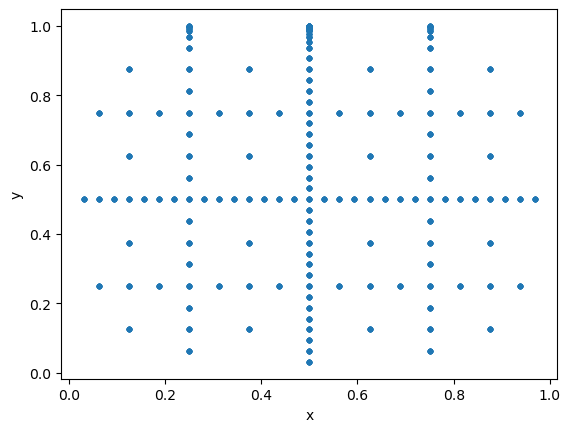

In [56]:
import matplotlib.pyplot as plt
# x0 = []
# x1 = []
# y = alpha
# x_train = []
# for i in range(gridStorage.getSize()):
#     gp = gridStorage.getPoint(i)
#     # x0.append(gp.getStandardCoordinate(0))
#     # x1.append(gp.getStandardCoordinate(1))
#     x_train.append([gp.getStandardCoordinate(0),gp.getStandardCoordinate(1)])
#     # opEval = createOperationEval(grid)
#     # vec = DataVector(0)
#     # vec.append(gp.getStandardCoordinate(0))
#     # vec.append(gp.getStandardCoordinate(1))
#     # print('vec', vec)
#     # print('function value', f(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1)))
#     # print('opEval', opEval.eval(alpha,vec))
    
#     # error[i] = pow(f(dataSet.get(i,0),dataSet.get(i,1))-opEval.eval(alpha,vec),2)
plt.figure(dpi=100)
plt.plot(x0,x1, '.')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(0,1)
# plt.ylim(0,1)

print(len(x0))

np.max(x1)

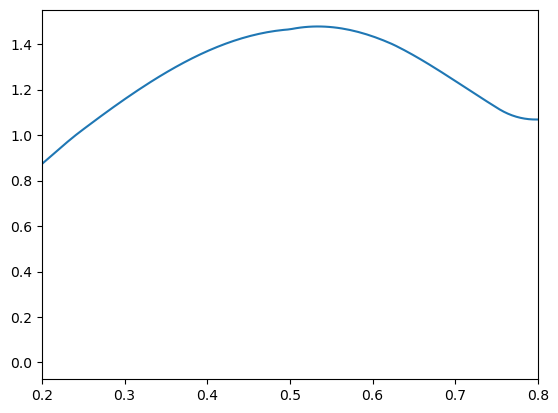

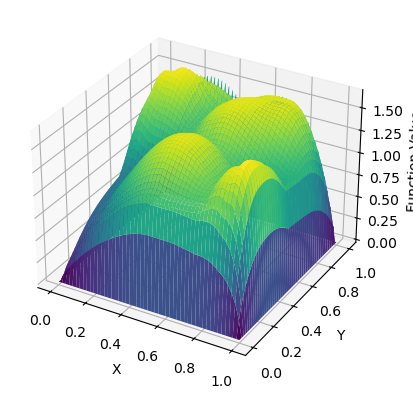

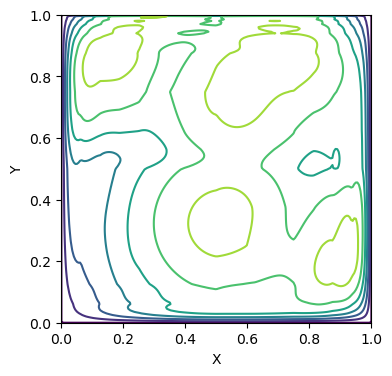

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pysgpp import DataVector, createOperationEval
# Define the function
def sgpp_OpEval(X, grid, alpha):
    vec = DataVector(0)
    vec.append(X[0])
    vec.append(X[1])
    opEval = createOperationEval(grid)
    z = opEval.eval(alpha,vec)
    return z 

sgpp_OpEval_f = lambda X: sgpp_OpEval(X, grid=grid, alpha=alpha)

# Generate 2D input data
x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(x, y)
Z = np.array([sgpp_OpEval_f(np.array([xi, yi])) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

## Slice
yy = 0.45
z = np.array([sgpp_OpEval_f(np.array([xi, yy])) for xi in x])
plt.figure()
plt.plot(x,z)
plt.xlim(0.2,0.8)

# # Create a 3D mesh plot
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')

# # Set plot labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('sgpp_OpEval_f(X, Y)')
# ax.view_init(elev=30, azim=0)
# Show plot
# plt.show()

azim = [30-90]

for a in azim:
    plot_surface(X,Y,Z, elev=30, azim=a)
    

1470
Zmax [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


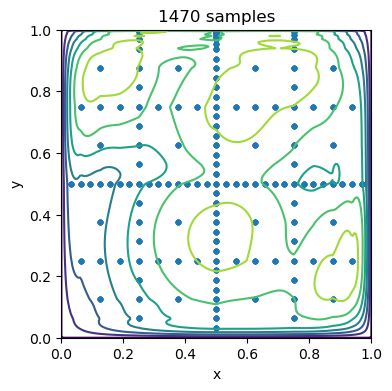

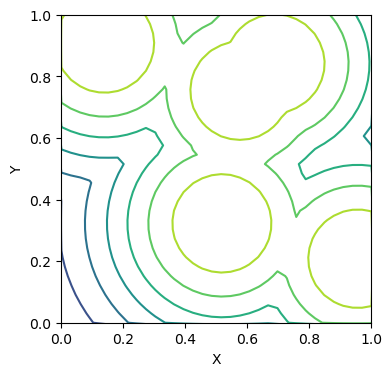

In [58]:
plt.figure(figsize=(4,4))
plt.plot(x0,x1, '.')
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.contour(X,Y,Z)
plt.title(f'{len(x0)} samples')
# plt.xlim(-0.5,1.5)
# plt.ylim(-0.5,1.5)
print(len(x0))

mmg.plot_2d_gaussians(onlyContour=True)